<a href="https://colab.research.google.com/github/Umercia/wind_power/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical learning for wind power

In this notebook we explore different model to predict the output power of wind turbine. We use data processed along the  [data processing notebook](https://github.com/Umercia/wind_power/blob/master/data_processing.ipynb)

01. <a href="#1-Import-Data">Import data</a>  
02. <a href="#2-Models-benchmark">Models benchmark</a>  
    2.1 <a href="#2.1-Linear-models">Linear models</a>  
    2.2 <a href="#2.2-Machine-Learning-models">Machine Learning models</a>  
    2.3 <a href="#2.3-Filtering-with-DBScan-on-torque/power">Filtering with DBScan on torque/power</a>  
03. <a href="#3-XGBoost-optimisation">XGBoost optimisation</a>  
    3.1 <a href="#3.1-New-atmospheric-variables">New atmospheric variables</a>  
    3.2 <a href="#3.2-Parameters-optimization">Parameters optimization</a>  
04. <a href="#4-Conclusion">Conclusion</a>  

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV

# mount drive from MyGoogleDrive
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.0 Import data

In [3]:
# importing

file_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/2.model_inputs/model_input.csv"

data = pd.read_csv(file_path,
                 index_col=[0],
                 header=[0],
                 parse_dates=True)

data.head(3)

,pwr_avg-WT11,pwr_avg-WT12,pwr_avg-WT13,pwr_avg-WT14,pwr_avg-WT21,pwr_avg-WT22,pwr_avg-WT23,pwr_avg-WT24,pwr_avg-WF,ws_avg-WT11,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_sin,month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,1375.0,1408.0,1658.0,1630.0,1351.0,1329.0,1428.0,1612.0,1473.875,9.3,...,0,0,0,0,0,0,0,0,0.5,0.866025
2014-01-01 00:10:00,1537.0,1560.0,1828.0,1706.0,1593.0,1522.0,1607.0,1765.0,1639.750,9.7,...,0,0,0,0,0,0,0,0,0.5,0.866025
2014-01-01 00:20:00,1492.0,1533.0,1813.0,1614.0,1541.0,1482.0,1606.0,1744.0,1603.125,9.6,...,0,0,0,0,0,0,0,0,0.5,0.866025


In [4]:
data.shape

(257808, 78)

In [0]:
# usefull functions

# reference model using power curve and wind
from sklearn.metrics import mean_squared_error

def pc_model(X_wind_speed, power_curve):
    """
    model that use a power curve to deduct power output
    Inputs:
        - wind_speed: array of wind speed
        - power_curve: dictionary {wind_speed : power}
   Output
        - y_pred: prediction array
    """
    round_ws = np.round(X_wind_speed,0).flatten()
    round_ws = round_ws.astype(int)
    
    y_pred = np.full(len(round_ws), 0)
    for ws, pwr in power_curve.items():
        mask = round_ws == ws
        y_pred[mask] = pwr
        
    return y_pred


def RMSE(y_true, y_pred, percent=False, nominal_pwr=3000):
    """ Compute Root mean Square Error of two series
    It also filter the NaN value"""
    
    mask = np.isnan(y_true) | np.isnan(y_pred)
    y_true_filt = y_true[~mask]
    y_pred_filt = y_pred[~mask]
    
    rmse = mean_squared_error(y_true_filt, y_pred_filt)**0.5
    
    if percent == False:
        return rmse
    else:
        rmse_perc = rmse/nominal_pwr
        return rmse_perc

    
def filter_nan(X, y):
    """ Compute Root mean Square Error of two series
    It also filter the NaN value"""
    
#     if type(X) is pd.core.series.Series:  # if X is 1D
#         X = pd.DataFrame(X)
    
    len_X = len(X)
    
    if len(X.shape) == 1:
        mask = np.isnan(X) | np.isnan(y)
    else:
        mask = np.isnan(X).any(axis=1) | np.isnan(y)
    
    
    X_filt = X[~mask]
    y_filt = y[~mask]
    leng_X_filt = len(X_filt)
    n_point_filt = len_X-leng_X_filt
    
    print("{}({:.2%}) rows have been filtered for NaN values ".format(n_point_filt,
                                                     float(n_point_filt)/len_X))
    
    return X_filt, y_filt


def plot_pc_train_test(xtrain, ytrain, xtest, ytest, ypred, title, y_max=3100):
    
    plt.figure(figsize=(21, 6))
    plt.suptitle(title,fontsize=25, fontweight="bold")
    
    # power curve plot of the train set ----------------------------------------
    plt.subplot(1,3,1)
    plt.title("train set", 
              size=16, fontweight="bold")
    plt.scatter(x=xtrain[:,0],
                    y=ytrain,
                    alpha=0.1,
                    s=5,
                    label="measurement")
    plt.scatter(x=xtest[:,0],
                    y=ypred,
                    alpha=0.3,
                    s=5,
                    c="orange",
                    label="prediction")
    plt.xlabel("wind speed [m/s]")
    plt.ylabel("power [kW]")
    plt.ylim(-50, y_max)
    plt.legend()
    
    # power curve plot of the test set -----------------------------------------
    plt.subplot(1,3,2)
    rmse_test = RMSE(ytest, ypred, percent=True)
    plt.title("test data - RMSE = {:.2%}".format(rmse_test),
              size=16, fontweight="bold")
    plt.scatter(x=xtest[:,0],
                    y=ytest,
                    alpha=0.1,
                    s=5,
                    label="measurement")
    plt.scatter(x=xtest[:,0],
                    y=ypred,
                    alpha=0.3,
                    s=5,
                    c="orange",
                    label="prediction")
    plt.xlabel("wind speed [m/s]")
    plt.ylabel("power [kW]")
    plt.ylim(-50, y_max)
    plt.legend()
    
    # y_pred veruse y_real plot ------------------------------------------------
    plt.subplot(1,3,3)
    r2 = np.corrcoef(ypred, ytest)[0,1]**2
    plt.title("y_real vesus y_pred - R2 = {:.1%}".format(r2), 
              size=16, fontweight="bold")
    plt.scatter(x=ytest,
                y=ypred,
                alpha=0.1,
                c="purple",
                s=5)
    plt.xlabel("y_real")
    plt.ylabel("y_pred")
    plt.ylim(-50, y_max)
    
    plt.show()    

In [7]:
# feature selection and split train/test 

# selection choices
selected_wtg = "WT14"
features = ["ws_avg-" + selected_wtg, u'wd_WF', u'hour', u'month']
end_train = "2015-12-31 23:50:00"
end_test = "2016-12-31 23:50:00"  

# extraction
X = data.loc[:,features]
y = data.loc[:,"pwr_avg-" + selected_wtg]
X, y = filter_nan(X, y)

# split data
X_train = X[:end_train]
X_test = X[end_train:end_test]
y_train = y[:end_train]
y_test = y[end_train:end_test]

# convert to simple np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

14859(5.76%) rows have been filtered for NaN values 
((92967, 4), (49633, 4), (92967,), (49633,))


 # 2.0 Models Benchmark
We will go thought 7 models and compare their accuracy. The first 3 are simple models, where we try to rebuild the main relation in between wind turbine power [kW] and the value of the wind speed [m/s].
In the second part (4 models) we will introduce two new features: Turbulence and air density. Those two features, should play a role in the turbine output.

## 2.1 Linear models

In this section we will run few simple models (power ~ wind speed). They will serve has baseline to compare with more advanced models.
1.   standard power curve provided by the manufactuer
2.   Sigmoid fit
3.   Linear regression with polynomial features




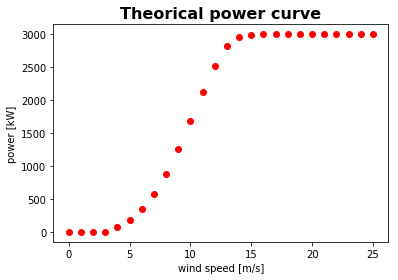

In [8]:
# read power curve

# dic format
file_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/Power Curve CDBO.csv"
power_curve = pd.read_csv(file_path, index_col=[0], sep=";")
power_curve = power_curve.to_dict()["Power"]

plt.title("Theorical power curve", size=16, fontweight="bold")
plt.scatter(x = power_curve.keys(),
           y = power_curve.values(),
           c = "r")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.show()

In [9]:
# for sigmoid fit
import scipy.optimize as opt   

# for Polynomial linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

calc_time = {}

# 1. standard power curve provided by the manufactuer  -------------------------
def std_pc_model(X_wind_speed, power_curve):
    """
    model that use a power curve to deduct power output
    Inputs:
        - wind_speed: array of wind speed
        - power_curve: dictionary {wind_speed : power}
   Output
        - y_pred: prediction array
    """
    round_ws = np.round(X_wind_speed,0).flatten()
    round_ws = round_ws.astype(int)
    
    y_pred = np.full(len(round_ws), 0)
    for ws, pwr in power_curve.items():
        mask = round_ws == ws
        y_pred[mask] = pwr
        
    return y_pred

t0 = time()
y_pred_pc = pc_model(X_test[:,0], power_curve)
calc_time["pc"] = time()-t0 
print("pc model done in {:.3f} secondes".format(calc_time["pc"]))

# 2. Sigmoid fit  --------------------------------------------------------------
def draw_me_a_sigmoid(x, x0, k):  
    return 3000 * 1.0/(1.0+np.exp(-x0*(x-k)))


def sigmoid_fit(X_test, X_train, y_train):
    # subsample, heavy calculation time
    n_sample = 2000 
    sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
    X_train_sub = X_train[sub_idx, 0]
    y_train_sub = y_train[sub_idx]

    (b, c), _ = opt.curve_fit(draw_me_a_sigmoid, 
                            X_train_sub.flatten(), 
                            y_train_sub, 
                            p0=[0.59, 9.7])

    y_pred = draw_me_a_sigmoid(X_test[:,0].flatten(), b, c)
    return y_pred
t0 = time()
y_pred_sig = sigmoid_fit(X_test[:,0][:,np.newaxis],
                         X_train[:,0][:,np.newaxis],
                         y_train)
calc_time["sig"] = time()-t0 
print("sigmoide model done in {:.3f} secondes".format(calc_time["sig"]))

# 3. Linear regression with polynomial features --------------------------------
linear_reg = Pipeline([('poly', PolynomialFeatures(degree=9)),
                ('linear', LinearRegression(fit_intercept=False,))])
t0 = time()
linear_reg = linear_reg.fit(X_train[:,0].reshape((-1, 1)), y_train)
y_pred_lin = linear_reg.predict(X_test[:,0].reshape((-1, 1)))
calc_time["lin"] = time()-t0
print("linear regression with polynomial feature model done in {:.3f} secondes".format(calc_time["lin"]))

pc model done in 0.003 secondes
sigmoide model done in 0.042 secondes
linear regression with polynomial feature model done in 0.078 secondes


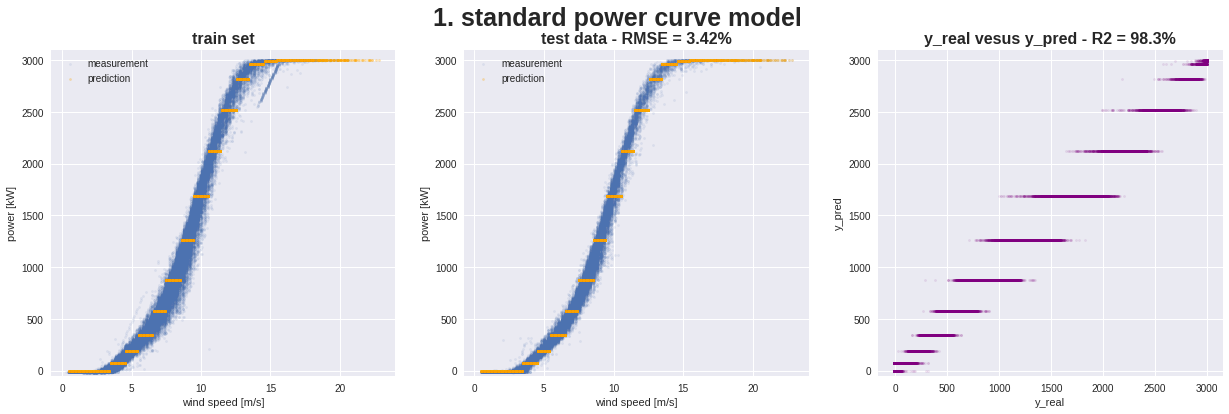

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_pc,"1. standard power curve model")

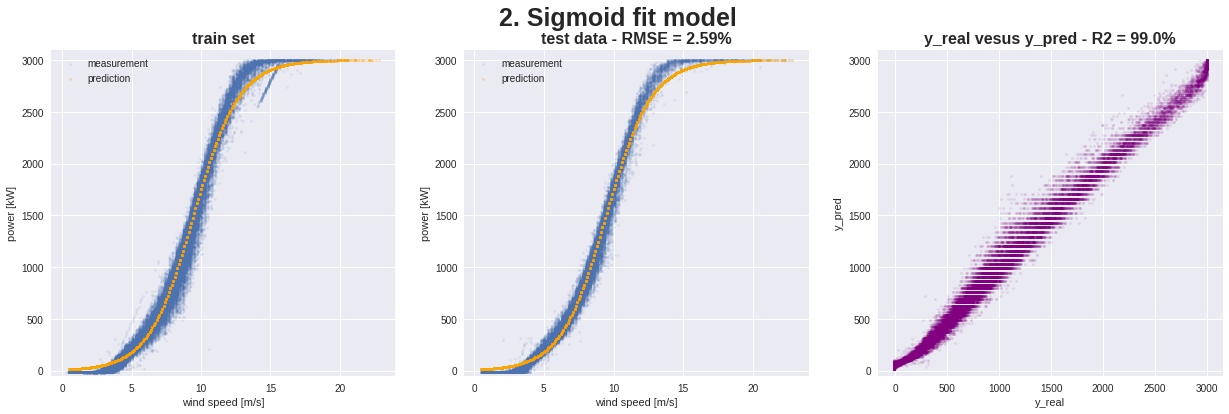

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_sig,"2. Sigmoid fit model")

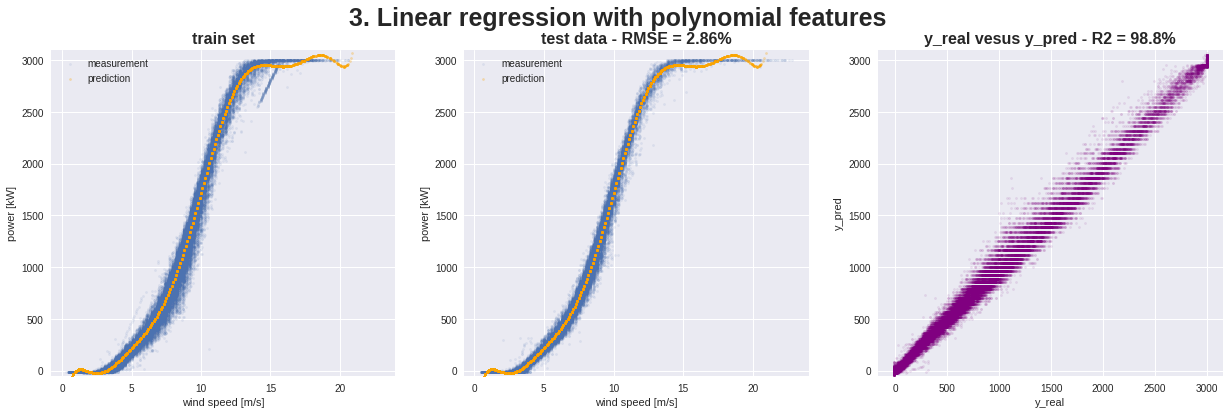

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_lin,"3. Linear regression with polynomial features")

We can already see athat we already have pretty good results in this base line. Starting with the theorical power curve, it is possible to reduce the rmse by fiting  lines to the data.  
However:

*   The sigmoide function seems to underestimate the real power curve after 11 m/s
*   The polynomial fit correctly the main part of the power curve (where the density of point is very important), but not so well on the border, and can give unrealistic values on those areas (below 0 or above the nominal power of 3000 kW)





## 2.2 Machine Learning models
In this section we test more advanced models. we also include the temporal feature (without cyclic encoding)
1.   Random Forest
2.   Knn
3.   Bagged decision Trees
4.  XGBoost



In [10]:
# 1. Random Forest
from sklearn.ensemble import RandomForestRegressor

t0 = time()
param_grid = {'max_depth': [3, 4, 5, None],
              "min_samples_leaf": [1, 3, 5]
             }

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=6)
rf_grid.fit(X_train, y_train)
y_pred_rf_grid = rf_grid.predict(X_test)
print("Done in {:.2f} minutes".format((time() - t0)/60))
t0 = time()

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rf done in: 1.0 min


In [13]:
# 2. k-nearest neighbors
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(axis=0)

# to give more weight to wind speed, we will mutiphy it by 10 (to grid search)
ws_weight = 30
X_train_scaled[:,0] = X_train_scaled[:,0]*ws_weight
X_test_scaled[:,0] = X_test_scaled[:,0]*ws_weight


t0 = time()
param_grid = {"n_neighbors": [5, 10, 15, 20],
              "weights": ["uniform", "distance"]
             }

knn_bagging_grid = GridSearchCV(neighbors.KNeighborsRegressor(n_jobs=-1), param_grid, cv=6)
knn_bagging_grid.fit(X_train, y_train)
y_pred_knn_grid = knn_bagging_grid.predict(X_test)
print("Done in {:.2f} minutes".format((time() - t0)/60))

Done in: 0.76 minutes


In [15]:
# 3. Bagged decision Trees

from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

n_sample = 10000
sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
X_train_sub = X_train[sub_idx]
y_train_sub = y_train[sub_idx]

t0 = time()
param_grid = {"bootstrap": [True, False],
              "bootstrap_features": [True, False]
             }

cart_bagging_grid = GridSearchCV(BaggingRegressor(n_estimators=20, n_jobs=-1), param_grid, cv=6)
cart_bagging_grid.fit(X_train, y_train)
y_pred_cart_grid = cart_bagging_grid.predict(X_test)
print("Done in: {:.2f} minutes".format((time() - t0)/60))

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done in: 2.32 minutes


In [16]:
# 4. XGBoost
import xgboost as xgb

t0 = time()
param_grid = {'max_depth': [1,2, 3, 5]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(n_jobs=-1), param_grid, cv=6)
xgb_grid.fit(X_train, y_train)
y_pred_xgb_grid = xgb_grid.predict(X_test)
print("Done in {:.2f} minutes".format((time() - t0)/60))

Done in 0.90 minutes


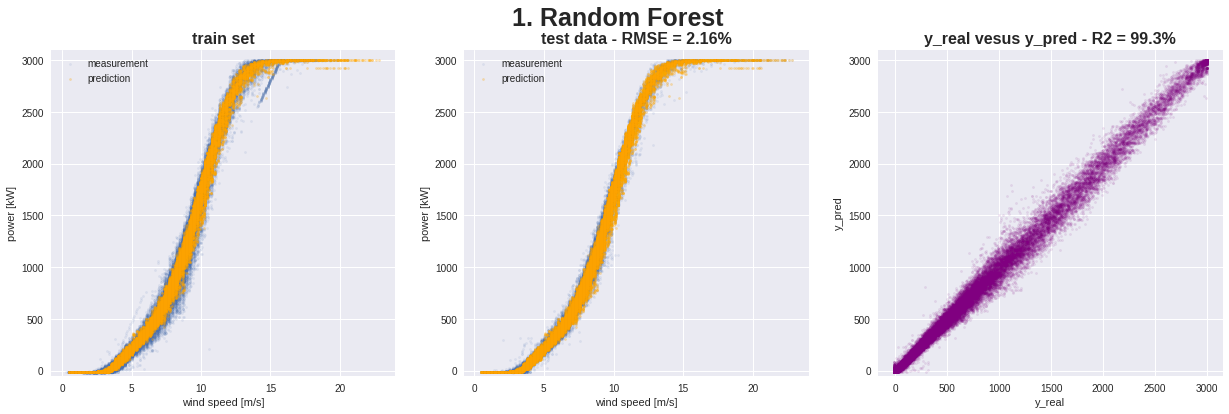

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_rf_grid, "1. Random Forest")

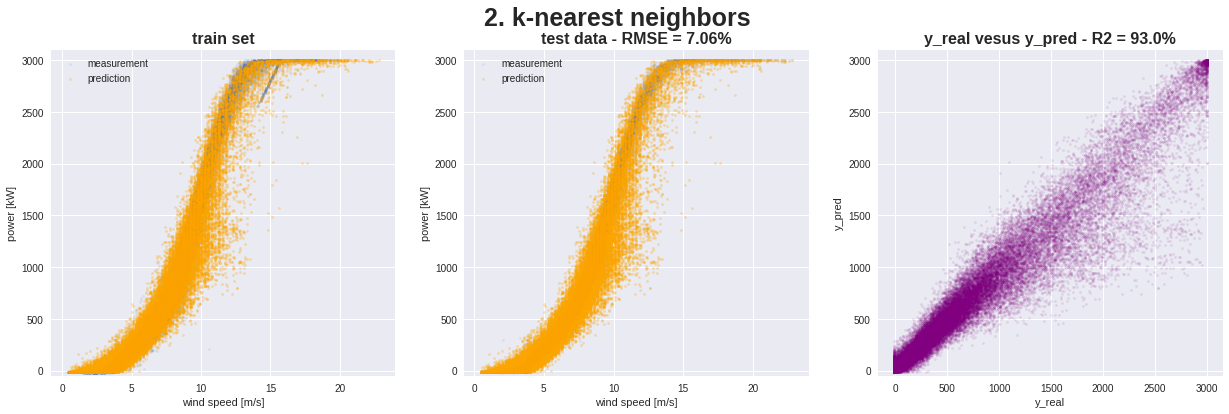

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_knn_grid, "2. k-nearest neighbors")

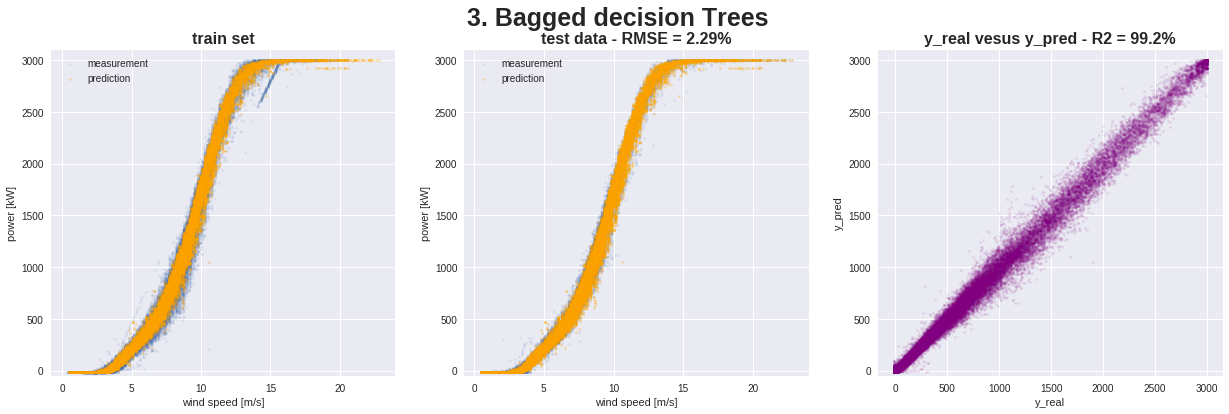

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_cart_grid, "3. Bagged decision Trees")

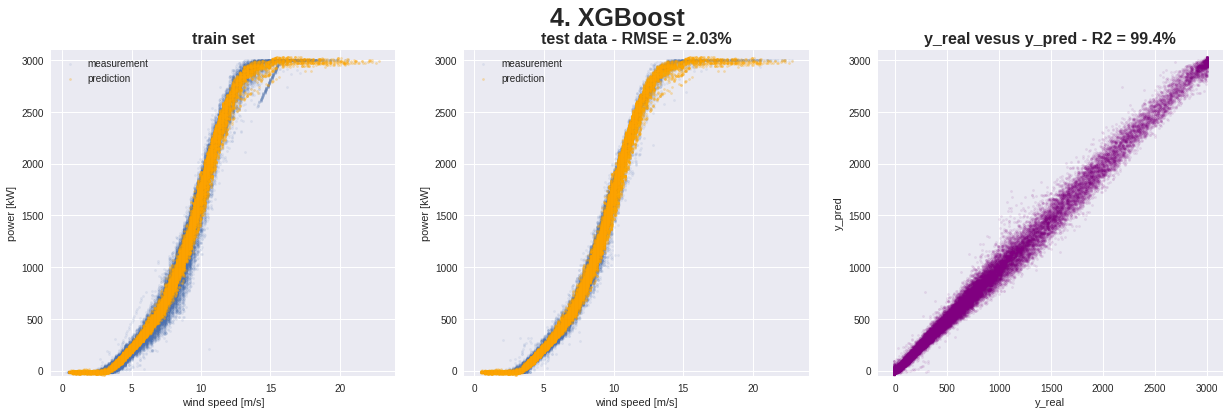

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb_grid, "4. XGBoost")

We can see that tree based model give pretty similar results. Knn on the other hand give very sparse results. Since this algorithm is based on distance, it migh be confused by the "wrong" impression on cyclic variable (direction 0-360, hours 0:24, or month 0.12).  Below we will try the same variable but encoded on cyclic (sin, cos).

In [0]:
# feature selection and split train/test 

# selection choices
selected_wtg = "WT14"
features = ["ws_avg-" + selected_wtg, u'wd_sin_avg',u'wd_cos_avg', u'month',
            u'hour_sin', u'hour_cos',u'month_sin', u'month_cos']
end_train = "2015-12-31 23:50:00"
end_test = "2016-12-31 23:50:00"   # change in power curve occur during  2017: to investiguate

# extraction
X = data.loc[:,features]
y = data.loc[:,"pwr_avg-" + selected_wtg]
X, y = filter_nan(X, y)

# split data
X_train = X[:end_train]
X_test = X[end_train:end_test]
y_train = y[:end_train]
y_test = y[end_train:end_test]

# convert to simple np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

14859(5.76%) rows have been filtered for NaN values 
((92967, 8), (49633, 8), (92967,), (49633,))


In [0]:
# 2. k-nearest neighbors
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(axis=0)

# to give more weight to wind speed, we will mutiphy it by 30 (to grid search)
ws_weight = 30
X_train_scaled[:,0] = X_train_scaled[:,0]*ws_weight
X_test_scaled[:,0] = X_test_scaled[:,0]*ws_weight


t0 = time()
param_grid = {"n_neighbors": [5, 10, 15, 20],
              "weights": ["uniform", "distance"]
             }

knn_bagging_grid = GridSearchCV(neighbors.KNeighborsRegressor(n_jobs=-1), param_grid, cv=6)
knn_bagging_grid.fit(X_train, y_train)
y_pred_knn_grid = knn_bagging_grid.predict(X_test)
print("Done in {:.2f} minutes".format((time() - t0)/60))

Knn optimized in: 1.0 min


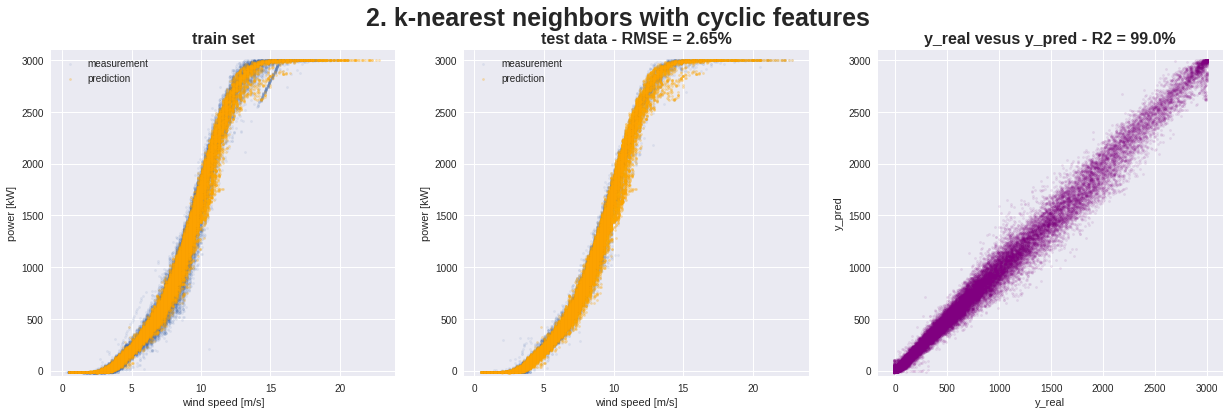

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_knn_grid, "2. k-nearest neighbors with cyclic features")

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


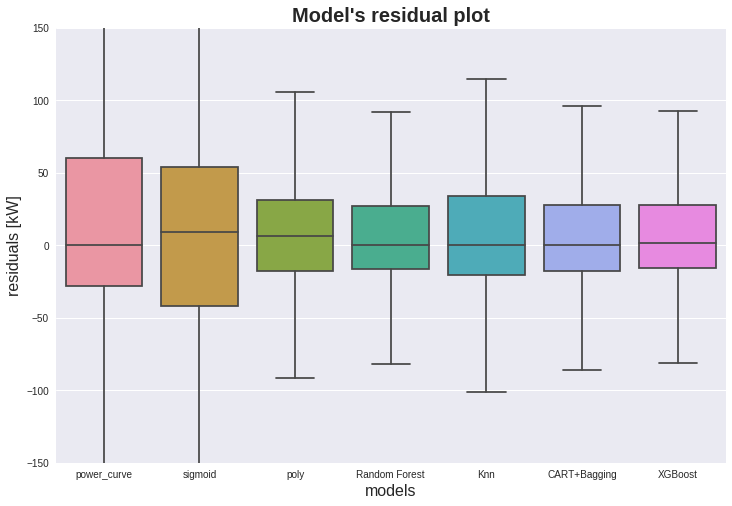

In [0]:
# resitual distribution plot
# inputs
residuals = pd.DataFrame({"power_curve": y_test - y_pred_pc,
                            "sigmoid": y_test - y_pred_sig,
                            "poly": y_test - y_pred_lin,
                            "Random Forest": y_test - y_pred_rf_grid,
                            "Knn": y_test - y_pred_knn_grid,
                            "CART+Bagging": y_test - y_pred_cart_grid,
                            "XGBoost": y_test - y_pred_xgb_grid     
                          })


residuals = residuals.melt()
residuals.sample(3)

# plot
plt.figure(figsize=(12,8))
plt.title("Model's residual plot", size=20, fontweight="bold" )
sns.boxplot(x="variable", y="value", data=residuals, order=["power_curve","sigmoid",
                            "poly","Random Forest","Knn", "CART+Bagging", "XGBoost"],
           whis=1.5, fliersize=0)
plt.ylim(-150, 150)
plt.ylabel("residuals [kW]", size=16)
plt.xlabel("models", size=16)
plt.show()

Algorithms using trees seems to perform better (RF, CART+Bagging+XGBoost). Polynomial and sigmoid are bias and tend to predict a little bit more power than reality.

#  3.0 Optimisation on XGBoost

## 3.1 New atmospheric variables
In this part, we will continue with the XGBoost model, and try the new features of turbulence and air density (that are actually somehow underlying below the temporal feature of month and hour and sometime the direction) and are in some extent real reason for power curve variation.

In [0]:
# feature selection and split train/test 

# selection choices
selected_wtg = "WT14"
features = ["ws_avg-" + selected_wtg, u'air_dens_avg-WF', u'ti_avg-WF', u'wd_WF']
end_train = "2015-12-31 23:50:00"
end_test = "2016-12-31 23:50:00"   # change in power curve occur during  2017: to investiguate

# extraction
X = data.loc[:,features]
y = data.loc[:,"pwr_avg-" + selected_wtg]
X, y = filter_nan(X, y)

# split data
X_train = X[:end_train]
X_test = X[end_train:end_test]
y_train = y[:end_train]
y_test = y[end_train:end_test]

# convert to simple np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

14859(5.76%) rows have been filtered for NaN values 
((92967, 4), (49633, 4), (92967,), (49633,))


In [0]:
# 4. XGBoost

param_grid = {'max_depth': [3]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(n_jobs=-1), param_grid, cv=6)
xgb_grid.fit(X_train, y_train)
y_pred_xgb_grid = xgb_grid.predict(X_test)

print("Done in {:.2f} minutes".format((time() - t0)/60))

('XGB done in: ', 0.0, ' min')


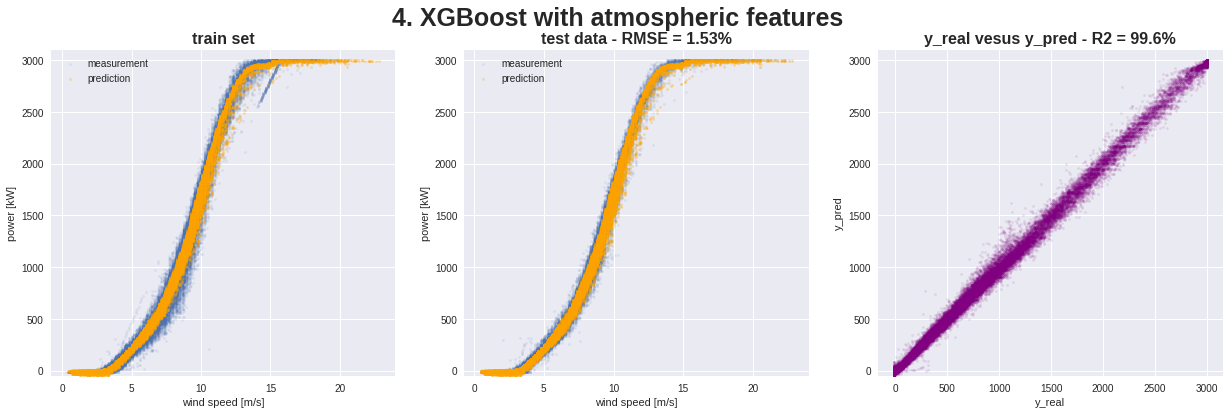

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb_grid, "4. XGBoost with atmospheric features")

## 3.2 Parameters optimization

In [0]:
# actual parameter for XGBoost
xgb_grid.get_params

<bound method GridSearchCV.get_params of GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring=None, verbose=0)>

In [0]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

params = {  
    "n_estimators": [100],
    "max_depth": np.arange(2,6,1),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": np.arange(0.5,1,.1),
    "subsample": np.arange(0.5,1,.1),
    "gamma": np.arange(0,100,20),
    "min_child_weight": np.arange(1,100,20),
    "reg_alpha": np.arange(0,1,0.2),
    "reg_lambda": np.arange(0,1,0.2),
}

gbm = xgb.XGBRegressor(nthreads=-1)
gs = RandomizedSearchCV(gbm, params,
                        cv = 5, n_iter = 100, 
                        scoring='r2',)  
gs.fit(X_train, y_train)  
y_pred_xgb_grid = gs.predict(X_test)

In [0]:
gs.get_params

<bound method RandomizedSearchCV.get_params of RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, nthreads=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': [100], 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]), 'reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8]), 'reg_lambda': array([0. , 0.2, 0.4, 0.6, 0.8]), 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]), 'min_child_weight': array([ 1, 21, 41, 61, 81]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6cb116989

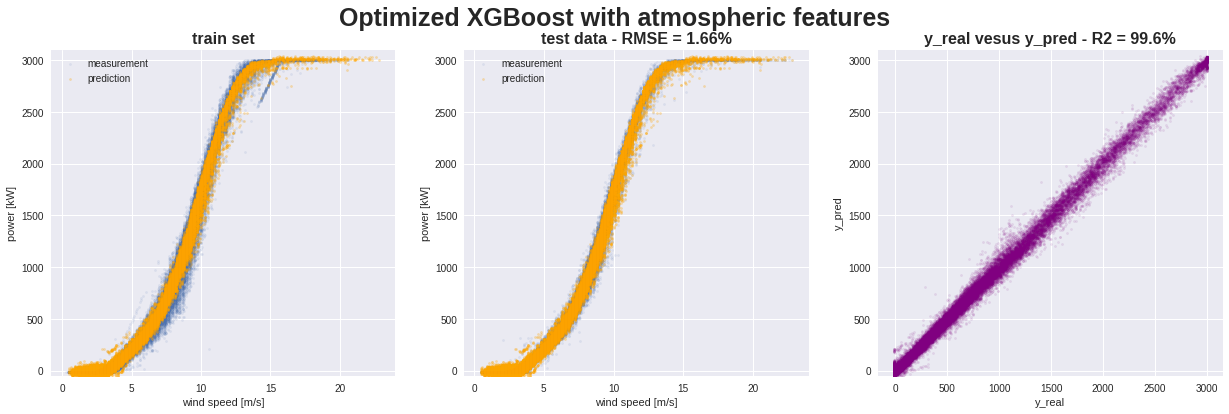

In [0]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb_grid, "Optimized XGBoost with atmospheric features ")

No improvement (same R² than before)

# 4.0 Conclusion

Starting with the normal power curve mode with an already quite low RMSE of 3.42%, we have gone thought different models and inputs. It finally end-up that the best model was XGBoost  (rmse of 1.6%, R² of 99.6%) using pure atmospheric features of wind speed, wind direction, turbulence and air density.
This should be taken into perspective that the wind farm site is quite simple in terms of topography and results might not be the same if applied on another wind farms.  
The fine filtering done during the data exploration to obtain the purest power curve play an important role in the model performance.
further idea of optimization:  
 

*   Incorporating some other atmospheric conditions as stability and/or wind shear. note that it will require some measurement devices on site. Stability has a big impact on wake effects, and can be quite relevant for big wind farms. 
*   Use turbine specific signal rather than the average of the wind turbines (wind speed, and turbulence). This migh help to catch some directional feature that occur only on some turbines. specially true for complexe terrain and heavy wake wind farms.

It could be interesting to also test if fited models from one turbine to another are similar. If there are, we can think of simplifying the problem by building/fitting a unique model.


# SANDBOX

In [0]:
WTGs =  ["WT11", "WT12", "WT13", "WT14", "WT21", "WT22", "WT23", "WT24"]
model_names = ["power_curve","sigmoid", "poly","Random Forest","Knn", "CART+Bagging", "XGBoost"]
results_RMSE = pd.DataFrame(0, index=WTGs, columns=model_names)
results_RMSE.head()

,power_curve,sigmoid,poly,Random Forest,Knn,CART+Bagging,XGBoost
WT11,0,0,0,0,0,0,0
WT12,0,0,0,0,0,0,0
WT13,0,0,0,0,0,0,0
WT14,0,0,0,0,0,0,0
WT21,0,0,0,0,0,0,0


In [0]:
# feature selection and split train/test 


for WTG in WTGs:
    # DATA -------------------------------------------------------------------------
    # selection choices
    features = ["ws_avg-" + WTG, u'wd_sin_avg',u'wd_cos_avg', u'month',
                u'hour_sin', u'hour_cos',u'month_sin', u'month_cos']
    end_train = "2015-12-31 23:50:00"
    end_test = "2016-12-31 23:50:00"   # change in power curve occur during  2017: to investiguate

    # extraction
    X = data.loc[:,features]
    y = data.loc[:,"pwr_avg-" + WTG]
    X, y = filter_nan(X, y)

    # split data
    X_train = X[:end_train]
    X_test = X[end_train:end_test]
    y_train = y[:end_train]
    y_test = y[end_train:end_test]

    # convert to simple np.array
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



    # MODEL ------------------------------------------------------------------------
    # 1. standard power curve provided by the manufactuer  -------------------------
    t0 = time()
    y_pred_pc = pc_model(X_test[:,0], power_curve)
    calc_time["pc"] = time()-t0 
    print("pc model done in {:.3f} secondes".format(calc_time["pc"]))

    # 2. sigmoid
    t0 = time()
    y_pred_sig = sigmoid_fit(X_test[:,0][:,np.newaxis],
                             X_train[:,0][:,np.newaxis],
                             y_train)
    calc_time["sig"] = time()-t0 
    print("sigmoide model done in {:.3f} secondes".format(calc_time["sig"]))

    # 3. Linear regression with polynomial features --------------------------------
    linear_reg = Pipeline([('poly', PolynomialFeatures(degree=9)),
                    ('linear', LinearRegression(fit_intercept=False,))])
    t0 = time()
    linear_reg = linear_reg.fit(X_train[:,0].reshape((-1, 1)), y_train)
    y_pred_lin = linear_reg.predict(X_test[:,0].reshape((-1, 1)))
    calc_time["lin"] = time()-t0
    print("linear regression with polynomial feature model done in {:.3f} secondes".format(calc_time["lin"]))


    # 4. Random Forest
    t0 = time()
    param_grid = {'max_depth': [4, None],
                  "min_samples_leaf": [1, 3]
                 }
    rf_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=6)
    rf_grid.fit(X_train, y_train)
    y_pred_rf_grid = rf_grid.predict(X_test)
    print("rf done in: {} min".format(round((time() - t0)/60,0)))
    t0 = time()


    # 5. k-nearest neighbors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled.mean(axis=0)
    # to give more weight to wind speed, we will mutiphy it by 30 (to grid search)
    ws_weight = 30
    X_train_scaled[:,0] = X_train_scaled[:,0]*ws_weight
    X_test_scaled[:,0] = X_test_scaled[:,0]*ws_weight
    t0 = time()
    param_grid = {"n_neighbors": [5],
                  "weights": ["uniform"]
                 }
    knn_bagging_grid = GridSearchCV(neighbors.KNeighborsRegressor(n_jobs=-1), param_grid, cv=6)
    knn_bagging_grid.fit(X_train, y_train)
    y_pred_knn_grid = knn_bagging_grid.predict(X_test)
    print("Knn optimized in: {} min".format(round((time() - t0)/60,0)))


    # 6. Bagged decision Trees
    n_sample = 10000
    sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
    X_train_sub = X_train[sub_idx]
    y_train_sub = y_train[sub_idx]
    t0 = time()
    param_grid = {"bootstrap": [True],
                  "bootstrap_features": [False]
                 }
    cart_bagging_grid = GridSearchCV(BaggingRegressor(n_estimators=20, n_jobs=-1), param_grid, cv=6)
    cart_bagging_grid.fit(X_train, y_train)
    y_pred_cart_grid = cart_bagging_grid.predict(X_test)
    print("Bagged decision Trees done in: {} min".format(round((time() - t0)/60,0)))


    # 7. XGBoost
    t0 = time()
    param_grid = {'max_depth': [3],
                 }

    xgb_grid = GridSearchCV(xgb.XGBRegressor(n_jobs=-1), param_grid, cv=6)
    xgb_grid.fit(X_train, y_train)
    y_pred_xgb_grid = xgb_grid.predict(X_test)
    print("XGB done in: ", round((time() - t0)/60,0), " min")


    "power_curve","sigmoid", "poly","Random Forest","Knn", "CART+Bagging", "XGBoost"

    results_RMSE.loc[WTG,"power_curve"] =  RMSE(y_test, y_pred_pc, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"sigmoid"] =  RMSE(y_test, y_pred_sig, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"poly"] =  RMSE(y_test, y_pred_lin, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"Random Forest"] =  RMSE(y_test, y_pred_rf_grid, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"Knn"] =  RMSE(y_test, y_pred_knn_grid, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"CART+Bagging"] =  RMSE(y_test, y_pred_cart_grid, percent=True, nominal_pwr=3000)
    results_RMSE.loc[WTG,"XGBoost"] =  RMSE(y_test, y_pred_xgb_grid, percent=True, nominal_pwr=3000)

results_RMSE

22816(8.85%) rows have been filtered for NaN values 
((89812, 8), (48427, 8), (89812,), (48427,))
pc model done in 0.002 secondes
sigmoide model done in 0.015 secondes
linear regression with polynomial feature model done in 0.074 secondes
rf done in: 1.0 min
Knn optimized in: 0.0 min
Bagged decision Trees done in: 1.0 min
('XGB done in: ', 0.0, ' min')
21486(8.33%) rows have been filtered for NaN values 
((89666, 8), (49082, 8), (89666,), (49082,))
pc model done in 0.002 secondes
sigmoide model done in 0.015 secondes
linear regression with polynomial feature model done in 0.069 secondes
rf done in: 1.0 min
Knn optimized in: 0.0 min
Bagged decision Trees done in: 1.0 min
('XGB done in: ', 0.0, ' min')
30679(11.90%) rows have been filtered for NaN values 
((84719, 8), (45306, 8), (84719,), (45306,))
pc model done in 0.002 secondes
sigmoide model done in 0.013 secondes
linear regression with polynomial feature model done in 0.061 secondes
rf done in: 1.0 min
Knn optimized in: 0.0 min
Bagg

,power_curve,sigmoid,poly,Random Forest,Knn,CART+Bagging,XGBoost
WT11,0.039614,0.026788,0.023594,0.023331,0.028548,0.023639,0.022009
WT12,0.033461,0.024753,0.021323,0.020179,0.025750,0.020495,0.019115
WT13,0.049588,0.028783,0.047088,0.020115,0.025336,0.020228,0.019412
WT14,0.034191,0.026186,0.028551,0.021925,0.028644,0.022346,0.020018
WT21,0.047323,0.023739,0.026409,0.024564,0.029159,0.024149,0.021525
WT22,0.038818,0.027699,0.025721,0.027015,0.033025,0.027308,0.024545
WT23,0.034511,0.021468,0.020021,0.016637,0.022347,0.016973,0.015354
WT24,0.037032,0.028767,0.025955,0.025938,0.031160,0.026404,0.024219


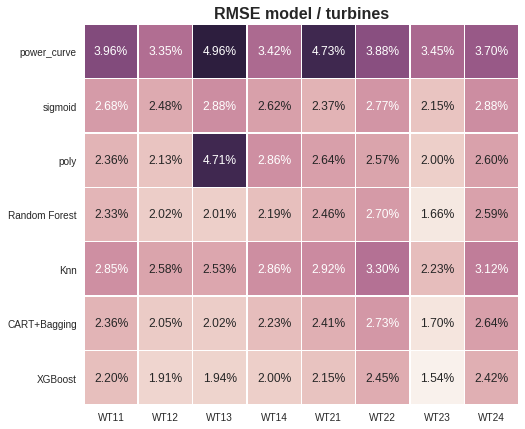

In [0]:
# plot
plt.figure(figsize=(9, 7))
sns.heatmap(results_RMSE.T, square=True, annot=True, linewidth=0.5, fmt = ".2%", cbar=False)
plt.title("RMSE model / turbines", fontweight="bold", size=16)
plt.show()

('XGB done in: ', 0.0, ' min')


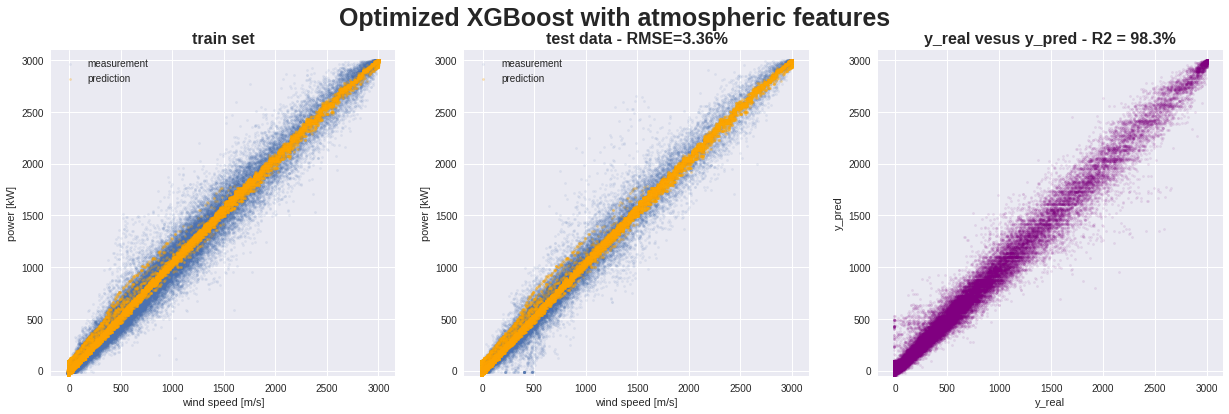

In [0]:
# A parameter grid for XGBoost
t0 = time()
import xgboost as xgb
# XGBoost

xgb_m = xgb.XGBRegressor(n_jobs=-1, max_depth=3)
xgb_m.fit(X_train, y_train)
y_pred_xgb = xgb_m.predict(X_test)


print("XGB done in: ", round((time() - t0)/60,0), " min")
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb, "Optimized XGBoost with atmospheric features ")